## 텍스트 마이닝

### 데이터 준비

In [1]:
# 관련 라이브러리를 호출합니다.
import os
import numpy as np
import pandas as pd
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
from tqdm.notebook import tqdm
from nltk import bigrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# 현재 작업 경로를 확인합니다.
os.getcwd()

'/Users/seonghona/Documents/Lectures/Customer/Archive/DBR_Project/code'

In [3]:
# data 폴더로 작업 경로를 변경합니다.
os.chdir(path = '../data')

In [4]:
# 현재 작업 경로에 있는 폴더명과 파일명을 확인합니다.
sorted(os.listdir())

['LDA.html',
 'Naver_News_Link.pkl',
 'Naver_News_ReCnt.pkl',
 'Naver_News_Reply.pkl',
 'Naver_News_Text.pkl',
 'Text_Data_Prep.pkl',
 'User_Dictionary.txt']

In [5]:
# pkl 파일을 읽고 newsReply를 생성합니다.
newsReply = pd.read_pickle(filepath_or_buffer = 'Naver_News_Reply.pkl')

In [6]:
# newsReply corrected의 처음 10행을 출력합니다.
for i in range(10):
    print(f'{i}: {newsReply["corrected"].iloc[i]}', end = '\n\n')

0: 나도 백종원 싫어하는데 요새 백종원 까이는 거 보면 뭔가 있어 보임.

1: 이 정도면 뒤에서 누가 일부러 성깔 부리고 다닌다 생각해도 이상하지 않은데.

2: 빽이지만 잘났다고 하는 건 알겠는데 왜 자꾸 못 죽여서 안 달 주가 조작하려 하나? 일부러 악재로 퍼뜨린 곳들 천지인데 갑자기 왜 맘만 죽이려 하나 개궁금.

3: 모든 언론에서 문제임 사람 하나 잘 키워 놓고 마녀 사냥하듯 지금이다 싶어 헐뜯고 악위적인 기사로 인해 이미지 쇄락 시켜 지들 밥벌이 이용 하는 기자들 가서 모른 행사장 취재하고 다녀라 위생 관련 해서 꼭 백종원만 그런지 그리고 마녀 사냥으로 자기들이 사람 죽여 놓고 또 다른 사람으로 옮겨서 꼭 그 사람이 문제인 마냥 지금 현재 대한민국인 언론이 제일 문제임 너네 부모 니 내 자식한데 부끄럽지 않는 모범된 사회 언론이 되길 바란다.

4: 더본코리아 죽이고 중국 자본 요식업 기업 들어올런가 보네.

5: 너무 악의적으로 패네 팩트만 보면 백종원 식당보다 동네 배달 마라탕집이 수십 배는 더 비위생적일걸?.

6: 요리에 요자도 모르는 자였다 어서 정식으로 배운 것도 아니고 기웃거다 운이 맞아 대박을 친 놈이었다 백 씨 양심이 우선이다.

7: 거의 스토커 수준인데 이 정도면 업무 방해인 듯.

8: 2023년에 있었던 일이네 사람 잡겠다 진짜 적당히 보도해라 알아서 시정 조치하고 자발적 개선할 시간은 줘야지 뭐 회사 망하고 누구 죽어야 그만할 건가?.

9: 백종원이 기자들에게 뭐 잘못했냐 걍 시도 때도 없이 물어 뜯기네 망할 때까지 할 기세야 이러다 망했네.



In [7]:
# 교정되지 않은 오탈자를 수작업으로 교정합니다.
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '성깔 부리고', repl = '성질부리고')
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '안 달', repl = '안달')
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '마녀 사냥', repl = '마녀사냥')
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '악위적', repl = '악의적')
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '쇄락', repl = '추락')
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '모른 행사장', repl = '모든 행사장')
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '기웃거다', repl = '기웃거리다')
newsReply['corrected'] = newsReply['corrected'].str.replace(pat = '업무 방해', repl = '업무방해')

### 형태소 분석

In [8]:
# 한글 형태소 분석기 객체를 생성합니다.
kiwi = Kiwi(model_type = 'sbg', typos = 'basic_with_continual_and_lengthening')

In [9]:
# 한글 맞춤법 검사 결과를 corrected에 할당합니다.
corrected = '복리후생으로 워라벨부터 챙기자.'

In [10]:
# corrected로 형태소 분석을 실행한 결과를 확인합니다.
kiwi.tokenize(text = corrected)

[Token(form='복리', tag='NNG', start=0, len=2),
 Token(form='후생', tag='NNG', start=2, len=2),
 Token(form='으로', tag='JKB', start=4, len=2),
 Token(form='워라밸', tag='NNG', start=7, len=3),
 Token(form='부터', tag='JX', start=10, len=2),
 Token(form='챙기', tag='VV', start=13, len=2),
 Token(form='자', tag='EF', start=15, len=1),
 Token(form='.', tag='SF', start=16, len=1)]

### 불용어 삭제

In [11]:
# 내장 불용어 객체를 생성합니다.
stopwords = Stopwords()

In [12]:
# 내장 불용어 목록을 확인합니다.
stopwords.stopwords

{('ᆫ', 'ETM'),
 ('ᆫ', 'JX'),
 ('ᆫ다', 'EF'),
 ('ᆯ', 'ETM'),
 ('가', 'JKS'),
 ('같', 'VA'),
 ('것', 'NNB'),
 ('게', 'EC'),
 ('겠', 'EP'),
 ('고', 'EC'),
 ('고', 'JKQ'),
 ('과', 'JC'),
 ('과', 'JKB'),
 ('그', 'MM'),
 ('그', 'NP'),
 ('기', 'ETN'),
 ('까지', 'JX'),
 ('나', 'NP'),
 ('년', 'NNB'),
 ('는', 'ETM'),
 ('는', 'JX'),
 ('다', 'EC'),
 ('다', 'EF'),
 ('다고', 'EC'),
 ('다는', 'ETM'),
 ('대하', 'VV'),
 ('더', 'MAG'),
 ('던', 'ETM'),
 ('도', 'JX'),
 ('되', 'VV'),
 ('되', 'XSV'),
 ('들', 'XSN'),
 ('등', 'NNB'),
 ('따르', 'VV'),
 ('때', 'NNG'),
 ('때문', 'NNB'),
 ('라', 'EC'),
 ('라는', 'ETM'),
 ('로', 'JKB'),
 ('를', 'JKO'),
 ('만', 'JX'),
 ('만', 'NR'),
 ('말', 'NNG'),
 ('며', 'EC'),
 ('면', 'EC'),
 ('면서', 'EC'),
 ('명', 'NNB'),
 ('받', 'VV'),
 ('보', 'VV'),
 ('부터', 'JX'),
 ('사람', 'NNG'),
 ('성', 'XSN'),
 ('수', 'NNB'),
 ('아니', 'VCN'),
 ('않', 'VX'),
 ('어', 'EC'),
 ('어', 'EF'),
 ('어서', 'EC'),
 ('어야', 'EC'),
 ('없', 'VA'),
 ('었', 'EP'),
 ('에', 'JKB'),
 ('에게', 'JKB'),
 ('에서', 'JKB'),
 ('와', 'JC'),
 ('와', 'JKB'),
 ('우리', 'NP'),
 ('원', 'NNB'),


In [13]:
# 형태소 분석을 실행하고 불용어를 삭제한 결과를 확인합니다.
kiwi.tokenize(text = corrected, stopwords = stopwords)

[Token(form='복리', tag='NNG', start=0, len=2),
 Token(form='후생', tag='NNG', start=2, len=2),
 Token(form='워라밸', tag='NNG', start=7, len=3),
 Token(form='챙기', tag='VV', start=13, len=2),
 Token(form='자', tag='EF', start=15, len=1)]

### 사용자 사전 추가

In [14]:
# 사용자 사전에 새로운 단어를 추가합니다.
kiwi.add_user_word(word = '복리후생', tag = 'NNG', score = 1)

True

In [15]:
# 사용자 사전을 적용하여 형태소 분석을 실행하고 불용어를 제거합니다.
tokens = kiwi.tokenize(text = corrected, stopwords = stopwords)

In [16]:
# tokens(형태소 분석 결과)를 확인합니다.
tokens

[Token(form='복리후생', tag='NNG', start=0, len=4),
 Token(form='워라밸', tag='NNG', start=7, len=3),
 Token(form='챙기', tag='VV', start=13, len=2),
 Token(form='자', tag='EF', start=15, len=1)]

In [17]:
# 첫 번째 형태소의 단어와 품사를 확인합니다.
tokens[0].form, tokens[0].tag

('복리후생', 'NNG')

### 품사 선택

In [18]:
# 형태소 분석 결과에서 선택할 품사(용언과 체언) 목록을 리스트로 생성합니다.
tag_v, tag_n = ['VV', 'VV-R', 'VV-I', 'VA', 'VA-R', 'VA-I'], ['NNG', 'NNP']

In [19]:
# 품사가 용언과 체언인 형태소만 선택하고, 품사가 용언일 때 종결어미 '다'를 결합합니다.
[token.form + '다' if token.tag in tag_v else token.form 
 for token in tokens if token.tag in tag_v + tag_n]

['복리후생', '워라밸', '챙기다']

### 형태소 분석 함수 생성

In [20]:
# 문서를 입력받아 형태소 분석을 실행하고 리스트로 반환하는 함수를 생성합니다.
def tokenizer(text):
    tokens = kiwi.tokenize(text = text, stopwords = stopwords)
    return [token.form + '다' if token.tag in tag_v else token.form
            for token in tokens if token.tag in tag_v + tag_n]

### BoW 생성: 문서 집합으로 형태소 분석 실행

In [21]:
# 형태소 분석 결과를 저장할 빈 리스트를 생성합니다.
morphs = []

# 문서 집합에서 각 문서를 형태소로 나누고 일부 품사를 남긴 morphs를 생성합니다.
for corrected in tqdm(newsReply['corrected']):
    tokens = tokenizer(text = corrected)
    morphs.append(tokens)

  0%|          | 0/20589 [00:00<?, ?it/s]

### BoW 확인: 사용자 사전에 추가할 단어 탐색

In [22]:
# 한글 맞춤법 검사를 실행한 문서와 형태소 분석 결과를 비교합니다.
for i in range(10):
    print(f'{i}: {newsReply["corrected"].iloc[i]}')
    print(f'{i}: {morphs[i]}', end = '\n\n')

0: 나도 백종원 싫어하는데 요새 백종원 까이는 거 보면 뭔가 있어 보임.
0: ['백종원', '싫어하다', '백종원', '까이', '있다', '보이다']

1: 이 정도면 뒤에서 누가 일부러 성질부리고 다닌다 생각해도 이상하지 않은데.
1: ['정도', '뒤', '성질', '부리다', '다니다', '생각', '이상']

2: 빽이지만 잘났다고 하는 건 알겠는데 왜 자꾸 못 죽여서 안달 주가 조작하려 하나? 일부러 악재로 퍼뜨린 곳들 천지인데 갑자기 왜 맘만 죽이려 하나 개궁금.
2: ['빽', '잘나다', '알다', '죽이다', '안달', '주가', '조작', '악재', '퍼뜨리다', '곳', '천지', '맘', '죽이다']

3: 모든 언론에서 문제임 사람 하나 잘 키워 놓고 마녀사냥하듯 지금이다 싶어 헐뜯고 악의적인 기사로 인해 이미지 추락 시켜 지들 밥벌이 이용 하는 기자들 가서 모든 행사장 취재하고 다녀라 위생 관련 해서 꼭 백종원만 그런지 그리고 마녀사냥으로 자기들이 사람 죽여 놓고 또 다른 사람으로 옮겨서 꼭 그 사람이 문제인 마냥 지금 현재 대한민국인 언론이 제일 문제임 너네 부모 니 내 자식한데 부끄럽지 않는 모범된 사회 언론이 되길 바란다.
3: ['언론', '문제', '키우다', '마녀사냥', '지금', '헐뜯다', '악의', '기사', '인하다', '이미지', '추락', '지', '밥벌이', '이용', '기자', '가다', '행사장', '취재', '다니다', '위생', '관련', '백종원', '그렇다', '마녀사냥', '죽이다', '옮기다', '문제', '대한민국', '언론', '문제', '부모', '자식', '부끄럽다', '모범', '사회', '언론', '바라다']

4: 더본코리아 죽이고 중국 자본 요식업 기업 들어올런가 보네.
4: ['코리아', '죽이다', '중국', '자본', '요식업', '기업', '들어오다']

5: 너무 악의적으로 패네 팩트만 보면 백종원 식당보다 동네 배달 마라탕집이 수십 배는 더 비위생적일걸?.
5: ['

### 사용자 사전용 텍스트 파일 생성 및 읽기

In [23]:
# 사용자 사전에 추가할 단어 목록과 단어의 품사 및 점수를 각각 리스트로 생성합니다.
words = ['악의적', '비위생', '대박', '업무방해', '자발적', '더본코리아']
tags = ['NNG'] * 5 + ['NNP']
scores = [1] * 6

In [24]:
# 사용자 사전 파일명을 지정합니다.
dict_file = 'User_Dictionary.txt'

In [25]:
# 사용자 사전을 텍스트 파일로 저장합니다.
# [참고] 단어, 품사, 점수 사이에 구분자(탭)를 설정하고 문장 마지막에 개행문자를 추가합니다.
with open(file = dict_file, mode = 'w') as file:
    for word, tag, score in zip(words, tags, scores):
        file.write(f'{word}\t{tag}\t{score}\n')

In [26]:
# 사용자 사전에 등록할 텍스트 파일을 읽습니다.
kiwi.load_user_dictionary(dict_path = dict_file)

6

### BoW 생성: 사용자 사전 적용하여 형태소 분석 실행

In [27]:
# 형태소 분석 결과를 저장할 빈 리스트를 생성합니다.
morphs = []

# 사용자 사전을 적용하여 문서 집합으로 형태소 분석을 실행하고 morphs를 생성합니다.
for corrected in tqdm(newsReply['corrected']):
    tokens = tokenizer(text = corrected)
    morphs.append(tokens)

  0%|          | 0/20589 [00:00<?, ?it/s]

In [28]:
# morphs(형태소로 나눈 문서 집합)의 처음 10개 원소를 확인합니다.
for i in range(10):
    print(f'{i}: {newsReply["corrected"].iloc[i]}')
    print(f'{i}: {morphs[i]}', end = '\n\n')

0: 나도 백종원 싫어하는데 요새 백종원 까이는 거 보면 뭔가 있어 보임.
0: ['백종원', '싫어하다', '백종원', '까이', '있다', '보이다']

1: 이 정도면 뒤에서 누가 일부러 성질부리고 다닌다 생각해도 이상하지 않은데.
1: ['정도', '뒤', '성질', '부리다', '다니다', '생각', '이상']

2: 빽이지만 잘났다고 하는 건 알겠는데 왜 자꾸 못 죽여서 안달 주가 조작하려 하나? 일부러 악재로 퍼뜨린 곳들 천지인데 갑자기 왜 맘만 죽이려 하나 개궁금.
2: ['빽', '잘나다', '알다', '죽이다', '안달', '주가', '조작', '악재', '퍼뜨리다', '곳', '천지', '맘', '죽이다']

3: 모든 언론에서 문제임 사람 하나 잘 키워 놓고 마녀사냥하듯 지금이다 싶어 헐뜯고 악의적인 기사로 인해 이미지 추락 시켜 지들 밥벌이 이용 하는 기자들 가서 모든 행사장 취재하고 다녀라 위생 관련 해서 꼭 백종원만 그런지 그리고 마녀사냥으로 자기들이 사람 죽여 놓고 또 다른 사람으로 옮겨서 꼭 그 사람이 문제인 마냥 지금 현재 대한민국인 언론이 제일 문제임 너네 부모 니 내 자식한데 부끄럽지 않는 모범된 사회 언론이 되길 바란다.
3: ['언론', '문제', '키우다', '마녀사냥', '지금', '헐뜯다', '악의적', '기사', '인', '이미지', '추락', '지', '밥벌이', '이용', '기자', '가다', '행사장', '취재', '다니다', '위생', '관련', '백종원', '그렇다', '마녀사냥', '죽이다', '옮기다', '문제', '대한민국', '언론', '문제', '부모', '자식', '부끄럽다', '모범', '사회', '언론', '바라다']

4: 더본코리아 죽이고 중국 자본 요식업 기업 들어올런가 보네.
4: ['더본코리아', '죽이다', '중국', '자본', '요식업', '기업', '들어오다']

5: 너무 악의적으로 패네 팩트만 보면 백종원 식당보다 동네 배달 마라탕집이 수십 배는 더 비위생적일걸?.
5: [

### 바이그램 생성

In [29]:
# morphs의 첫 번째 원소에서 연속하는 두 단어를 튜플로 묶은 bg(바이그램)를 생성합니다.
bg = bigrams(sequence = morphs[0])

In [30]:
# bg(바이그램)를 리스트로 변환하여 결과를 확인합니다.
list(bg)

[('백종원', '싫어하다'), ('싫어하다', '백종원'), ('백종원', '까이'), ('까이', '있다'), ('있다', '보이다')]

In [31]:
# bg(바이그램)를 저장할 빈 리스트를 생성합니다.
bgs = []

# morphs에서 연속하는 두 단어를 묶은 튜플을 bgs에 결합합니다.
for i in range(len(morphs)):
    bg = bigrams(sequence = morphs[i])
    bgs += list(bg)

In [32]:
# bgs(바이그램을 저장한 리스트)를 확인합니다.
bgs

[('백종원', '싫어하다'),
 ('싫어하다', '백종원'),
 ('백종원', '까이'),
 ('까이', '있다'),
 ('있다', '보이다'),
 ('정도', '뒤'),
 ('뒤', '성질'),
 ('성질', '부리다'),
 ('부리다', '다니다'),
 ('다니다', '생각'),
 ('생각', '이상'),
 ('빽', '잘나다'),
 ('잘나다', '알다'),
 ('알다', '죽이다'),
 ('죽이다', '안달'),
 ('안달', '주가'),
 ('주가', '조작'),
 ('조작', '악재'),
 ('악재', '퍼뜨리다'),
 ('퍼뜨리다', '곳'),
 ('곳', '천지'),
 ('천지', '맘'),
 ('맘', '죽이다'),
 ('언론', '문제'),
 ('문제', '키우다'),
 ('키우다', '마녀사냥'),
 ('마녀사냥', '지금'),
 ('지금', '헐뜯다'),
 ('헐뜯다', '악의적'),
 ('악의적', '기사'),
 ('기사', '인'),
 ('인', '이미지'),
 ('이미지', '추락'),
 ('추락', '지'),
 ('지', '밥벌이'),
 ('밥벌이', '이용'),
 ('이용', '기자'),
 ('기자', '가다'),
 ('가다', '행사장'),
 ('행사장', '취재'),
 ('취재', '다니다'),
 ('다니다', '위생'),
 ('위생', '관련'),
 ('관련', '백종원'),
 ('백종원', '그렇다'),
 ('그렇다', '마녀사냥'),
 ('마녀사냥', '죽이다'),
 ('죽이다', '옮기다'),
 ('옮기다', '문제'),
 ('문제', '대한민국'),
 ('대한민국', '언론'),
 ('언론', '문제'),
 ('문제', '부모'),
 ('부모', '자식'),
 ('자식', '부끄럽다'),
 ('부끄럽다', '모범'),
 ('모범', '사회'),
 ('사회', '언론'),
 ('언론', '바라다'),
 ('더본코리아', '죽이다'),
 ('죽이다', '중국'),
 ('중국', '자본'),
 ('자본', '요식업'),


In [33]:
# bgs를 시리즈로 변환하여 원소별 도수를 계산하고 처음 20개를 확인합니다.
pd.Series(data = bgs).value_counts().head(n = 20)

(돈, 벌다)        406
(방송, 나오다)      280
(골목, 식당)       225
(문어, 발)        178
(사다, 먹다)       158
(사기, 치다)       141
(빽, 다방)        132
(골목, 상권)       127
(백종원, 죽이다)     125
(신경, 쓰다)       122
(홍콩, 반점)       121
(농약, 통)        120
(농가, 살리다)      120
(티브이, 나오다)     119
(백, 대표)        111
(방송, 출연)        92
(빽, 햄)          87
(욕, 먹다)         79
(가지다, 장난치다)     77
(주식, 상장)        76
dtype: int64

### 바이그램의 일부 단어를 포함하는 문서 인덱스 확인

In [34]:
# 사용자 사전에 추가할 단어를 포함하면 True, 그렇지 않으면 False인 cond를 생성합니다.
cond = newsReply['corrected'].str.contains(pat = '골목식당|문어발|빽다방|골목상권|홍콩반점|빽햄')

In [35]:
# 사용자 사전에 추가할 단어를 포함하는 문서의 인덱스를 확인합니다.
indices = np.where(cond)[0]
print(indices)

[  114   169   196   222   241   243   269   304   322   352   373   388
   390   392   393   399   449   465   492   515   545   546   688   693
   703   751   775   906  1046  1096  1183  1277  1531  1542  1550  1564
  1615  1692  1698  1716  1737  1771  1810  1905  2048  2051  2052  2063
  2131  2461  2574  2667  2834  2935  3167  3365  3385  3547  3591  3644
  3654  3657  3731  3800  3802  3806  3850  3892  3915  3969  3973  4022
  4042  4053  4152  4170  4256  4310  4331  4356  4405  4408  4415  4439
  4478  4498  4505  4553  4619  4748  4765  4797  4799  4865  4879  4887
  4904  4952  4989  5049  5074  5082  5143  5162  5171  5224  5273  5436
  5439  5488  5505  5518  5520  5546  5567  5580  5646  5766  5840  5893
  5897  6002  6017  6029  6092  6153  6179  6229  6258  6295  6296  6304
  6330  6335  6468  6540  6555  6585  6629  6671  6719  6726  6781  6789
  6912  6956  6958  6964  6965  6971  6978  6980  6994  6999  7017  7025
  7027  7056  7099  7109  7139  7188  7201  7293  7

In [36]:
# newsReply corrected에서 indices에 해당하는 문서를 확인합니다.
for i in indices[0:10]:
    print(f'{i}: {newsReply["corrected"].iloc[i]}')
    print(f'{i}: {morphs[i]}', end = '\n\n')

114: 백종원은 골목식당 살린다고 떠들더구먼 자기는 지 이름을 이용해 문어발식으로 사업을 확장해 서민들의 골목식당을 다 잡아 먹었지 저런 사람들은 사업을 해야지 성심당 같은 보고 배워라 사업가가 아닌 장사꾼.
114: ['백종원', '골목', '식당', '살리다', '떠들다', '이름', '이용', '문어', '발', '사업', '확장', '서민', '골목', '식당', '잡다', '먹다', '사업', '성심당', '배우다', '사업가', '장사']

169: 더본 계열 음식 사 먹지 마라 홍콩반점 등등.
169: ['계열', '음식', '사다', '먹다', '홍콩', '반점']

196: 홍콩반점 짜장데이 2000원 행사나 해라 반편아.
196: ['홍콩', '반점', '짜장', '데이', '원', '행사']

222: 작은 회사가 대표의 유명로 갑자기 성장하고 하니 이래저래 부족한 시스템이 수면 위로 노출되는 듯 쉽지 않죠 골목식당에서 장사꾼들 훈계하듯이 본인도 전문 경영인들에게 호되게 훈 계 한번 받고 업그레이드 되시길 방송 활동은 이제 좀 우선순위에서 내려 놓으시고.
222: ['작다', '회사', '대표', '유명', '성장', '부족', '시스템', '수면', '위', '노출', '쉽다', '골목', '식당', '장사', '훈계', '본인', '전문', '경영인', '호되다', '훈', '받다', '업그레이드', '방송', '활동', '우선순위', '내리다', '놓다']

241: 백종원 죽이기가 아니라 이 정도면 진작 죽었어야 되는 거 아니냐 이미지 포장 무분별 문어발 확장 관리는 안 해 프랜차이즈 폐업률에 돈은 자기 혼자 벌어 국민 건강 안중에도 없는 위생도 개판 무슨 국민 멘토가 이랬냐고 공익적 인물인 척을 어지간히 했어야지.
241: ['백종원', '죽이다', '정도', '죽다', '이미지', '포장', '분별', '문어', '발', '확장', '관리', '프랜차이즈', '폐업', '돈', '혼자', '벌다', '국민', '건강', '안중'

### 사용자 사전용 텍스트 파일에 추가

In [37]:
# 사용자 사전에 추가할 단어 목록과 단어의 품사 및 점수를 각각 리스트로 생성합니다.
words = ['더본', '골목식당', '빽다방', '홍콩반점', '짜장데이', '빽햄', '남극의 세프', '흑백 요리사', 
         '전문경영인', '장사꾼', '문어발', '골목상권', '소상공인']
tags = ['NNP'] * 8 + ['NNG'] * 5
scores = [1] * 13

In [38]:
# 사용자 사전을 텍스트 파일로 저장합니다.
# [참고] 단어, 품사, 점수 사이에 구분자(탭)를 설정하고 문장 마지막에 개행문자를 추가합니다.
with open(file = dict_file, mode = 'a') as file:
    for word, tag, score in zip(words, tags, scores):
        file.write(f'{word}\t{tag}\t{score}\n')

In [39]:
# 사용자 사전에 등록할 텍스트 파일을 읽습니다.
kiwi.load_user_dictionary(dict_path = dict_file)

12

### BoW 생성: 사용자 사전 적용하여 형태소 분석 실행

In [40]:
# 형태소 분석 결과를 저장할 빈 리스트를 생성합니다.
morphs = []

# 사용자 사전을 적용하여 문서 집합으로 형태소 분석을 실행하고 morphs를 생성합니다.
for corrected in tqdm(newsReply['corrected']):
    tokens = tokenizer(text = corrected)
    morphs.append(tokens)

  0%|          | 0/20589 [00:00<?, ?it/s]

In [41]:
# morphs(형태소로 나눈 문서 집합)의 처음 10개 원소를 확인합니다.
for i in indices[0:10]:
    print(f'{i}: {newsReply["corrected"].iloc[i]}')
    print(f'{i}: {morphs[i]}', end = '\n\n')

114: 백종원은 골목식당 살린다고 떠들더구먼 자기는 지 이름을 이용해 문어발식으로 사업을 확장해 서민들의 골목식당을 다 잡아 먹었지 저런 사람들은 사업을 해야지 성심당 같은 보고 배워라 사업가가 아닌 장사꾼.
114: ['백종원', '골목식당', '살리다', '떠들다', '이름', '이용', '문어발', '사업', '확장', '서민', '골목식당', '잡다', '먹다', '사업', '성심당', '배우다', '사업가', '장사꾼']

169: 더본 계열 음식 사 먹지 마라 홍콩반점 등등.
169: ['더본', '계열', '음식', '사다', '먹다', '홍콩반점']

196: 홍콩반점 짜장데이 2000원 행사나 해라 반편아.
196: ['홍콩반점', '짜장데이', '행사']

222: 작은 회사가 대표의 유명로 갑자기 성장하고 하니 이래저래 부족한 시스템이 수면 위로 노출되는 듯 쉽지 않죠 골목식당에서 장사꾼들 훈계하듯이 본인도 전문 경영인들에게 호되게 훈 계 한번 받고 업그레이드 되시길 방송 활동은 이제 좀 우선순위에서 내려 놓으시고.
222: ['작다', '회사', '대표', '유명', '성장', '부족', '시스템', '수면', '위', '노출', '쉽다', '골목식당', '장사꾼', '훈계', '본인', '전문', '경영인', '호되다', '훈', '받다', '업그레이드', '방송', '활동', '우선순위', '내리다', '놓다']

241: 백종원 죽이기가 아니라 이 정도면 진작 죽었어야 되는 거 아니냐 이미지 포장 무분별 문어발 확장 관리는 안 해 프랜차이즈 폐업률에 돈은 자기 혼자 벌어 국민 건강 안중에도 없는 위생도 개판 무슨 국민 멘토가 이랬냐고 공익적 인물인 척을 어지간히 했어야지.
241: ['백종원', '죽이다', '정도', '죽다', '이미지', '포장', '분별', '문어발', '확장', '관리', '프랜차이즈', '폐업', '돈', '혼자', '벌다', '국민', '건강', '안중', '위생', '개판', '국민', '멘토', '이렇

### morphs 원소 전처리

In [42]:
# 형태소(단어)에 있는 공백을 제거하고 morphs에 재할당합니다.
# [참고] 사용자 사전에 추가한 단어(남극의 세프, 흑백 요리사 등)에 공백이 있습니다.
morphs = [[j.replace(' ', '') for j in i] for i in morphs]

In [43]:
# morphs의 원소(리스트)를 하나의 문자열로 결합하고 corpus에 할당합니다.
corpus = [' '.join(i) for i in morphs]

In [44]:
# corpus의 처음 10개 원소를 확인합니다.
corpus[0:10]

['백종원 싫어하다 백종원 까이 있다 보이다',
 '정도 뒤 성질 부리다 다니다 생각 이상',
 '빽 잘나다 알다 죽이다 안달 주가 조작 악재 퍼뜨리다 곳 천지 맘 죽이다',
 '언론 문제 키우다 마녀사냥 지금 헐뜯다 악의적 기사 인 이미지 추락 지 밥벌이 이용 기자 가다 행사장 취재 다니다 위생 관련 백종원 그렇다 마녀사냥 죽이다 옮기다 문제 대한민국 언론 문제 부모 자식 부끄럽다 모범 사회 언론 바라다',
 '더본코리아 죽이다 중국 자본 요식업 기업 들어오다',
 '악의적 패다 팩트 백종원 식당 동네 배달 마라탕 집 배 비위생',
 '요리 자 모르다 자 정식 배우다 기웃거리다 운 맞다 대박 치다 백 양심 우선',
 '스토커 수준 정도 업무방해',
 '잡다 보도 알다 시정 조치 자발적 개선 시간 주다 회사 망하다 죽다',
 '백종원 기자 시 물다 뜯다 망하다 기세 이러다 망하다']

### 문서-단어 행렬 생성

In [45]:
# 단어 도수에 역 문서 도수(가중치)를 곱하는 객체를 생성합니다.
tv = TfidfVectorizer(min_df = 0.001)

In [46]:
# TF-IDF를 성분으로 갖는 문서-단어 행렬을 생성합니다.
dtm = tv.fit_transform(raw_documents = corpus).toarray()

### 문서-단어 행렬 확인

In [47]:
# dtm을 데이터프레임으로 변환합니다.
dtm = pd.DataFrame(data = dtm, columns = tv.get_feature_names_out())

In [48]:
# dtm의 처음 10행을 확인합니다.
dtm.head(n = 10)

,가게,가격,가공,가깝다,가능,가다,가르치다,가리다,가맹점,가맹점주,...,회장,효과,후발,훈계,훈수,흑백요리사,흘리다,희대,힘내다,힘들다
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.10977,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# dtm의 행 개수와 열 개수를 확인합니다.
dtm.shape

(20589, 1003)

In [50]:
# dtm의 단어별 도수 합계를 termFreqs에 할당합니다.
termFreqs = dtm.sum().sort_values(ascending = False)

In [51]:
# termFreqs의 처음 20행을 확인합니다.
termFreqs.head(n = 20)

백종원    726.220808
방송     424.187036
나오다    406.792334
가다     400.422657
먹다     374.046559
사기     287.443287
좋다     279.637298
쓰다     238.933415
알다     236.388705
장사꾼    233.664162
음식     230.719296
많다     224.666260
있다     214.869637
상장     209.083129
보이다    207.518674
회사     198.458838
인간     198.060720
그렇다    195.050504
사다     194.128294
벌다     188.658223
dtype: float64

### 외부 파일로 저장

In [52]:
# morphs와 dtm을 pkl 파일로 저장합니다.
pd.to_pickle(obj = [morphs, dtm], filepath_or_buffer = 'Text_Data_Prep.pkl')

In [53]:
# 현재 작업 경로에 있는 폴더명과 파일명을 확인합니다.
sorted(os.listdir())

['LDA.html',
 'Naver_News_Link.pkl',
 'Naver_News_ReCnt.pkl',
 'Naver_News_Reply.pkl',
 'Naver_News_Text.pkl',
 'Text_Data_Prep.pkl',
 'User_Dictionary.txt']

## 데이터 시각화

### 시각화 옵션 설정

In [54]:
# 관련 라이브러리를 호출합니다.
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [55]:
# 현재 사용 중인 컴퓨터에 설치한 전체 폰트 파일명을 리스트로 반환합니다.
fontList = fm.findSystemFonts(fontext = 'ttf')

In [56]:
# fontList를 확인합니다.
fontList

['/Users/seonghona/Library/Fonts/NanumSquareOTF_acL.otf',
 '/System/Library/Fonts/Supplemental/Courier New.ttf',
 '/System/Library/Fonts/Supplemental/PartyLET-plain.ttf',
 '/System/Library/Fonts/Supplemental/Wingdings 3.ttf',
 '/System/Library/Fonts/Supplemental/STIXSizOneSymBol.otf',
 '/System/Library/Fonts/Supplemental/NotoSansEgyptianHieroglyphs-Regular.ttf',
 '/System/Library/Fonts/Supplemental/BigCaslon.ttf',
 '/System/Library/Fonts/Supplemental/STIXIntDBol.otf',
 '/System/Library/Fonts/Supplemental/Times New Roman.ttf',
 '/System/Library/Fonts/Supplemental/Arial Unicode.ttf',
 '/Users/seonghona/Library/Fonts/NanumBarunGothic-YetHangul.ttf',
 '/System/Library/Fonts/Supplemental/Telugu Sangam MN.ttc',
 '/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf',
 '/System/Library/Fonts/SFHebrewRounded.ttf',
 '/System/Library/Fonts/Supplemental/STIXTwoText.ttf',
 '/Users/seonghona/Library/Fonts/NanumSquareB.ttf',
 '/System/Library/Fonts/Supplemental/Sinhala Sangam MN.ttc',
 '/Sy

In [57]:
# fontList에서 특정 문자열(폰트명)을 포함하는 파일명을 선택합니다.
fontPath = [font for font in fontList if 'Gowun' in font]

In [58]:
# fontPath를 확인합니다.
fontPath

['/Users/seonghona/Library/Fonts/GowunBatang-Regular.ttf',
 '/Users/seonghona/Library/Fonts/GowunDodum-Regular.ttf',
 '/Users/seonghona/Library/Fonts/GowunBatang-Bold.ttf']

In [59]:
# for 반복문으로 컴퓨터에 설치한 폰트명을 출력합니다.
for font in fontPath:
    print(fm.FontProperties(fname = font).get_name())

Gowun Batang
Gowun Dodum
Gowun Batang


In [60]:
# 한글폰트와 글자 크기를 설정합니다.
plt.rc(group = 'font', family = 'Gowun Batang', size = 10)

In [61]:
# 그래프 크기와 해상도를 설정합니다.
plt.rc(group = 'figure', figsize = (12, 4), dpi = 150)

### 워드 클라우드 시각화

In [62]:
# 단어와 TF-IDF 합계를 저장할 빈 딕셔너리를 생성합니다.
freq = dict()

# for 반복문으로 워드 클라우드 시각화용 딕셔너리를 생성합니다.
# [참고] 키는 단어, 값은 TF-IDF 합계입니다.
for word in dtm.columns:
    freq[word] = dtm[word].sum()

In [63]:
# 워드 클라우드 객체를 생성합니다.
wc = WordCloud(
    font_path = fontPath[1],
    width = 800, 
    height = 800, 
    background_color = 'black', 
    colormap = 'Dark2'
)

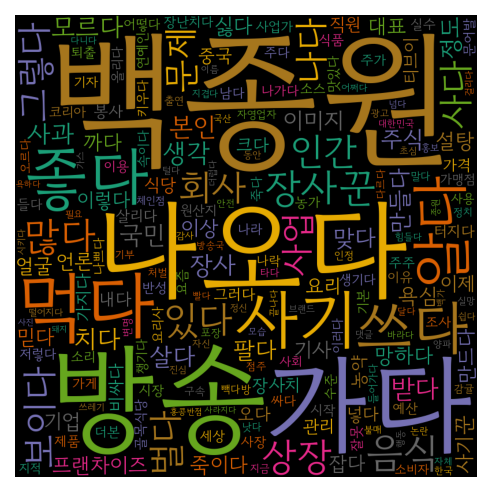

In [64]:
# 워드 클라우드를 시각화합니다.
plt.figure(figsize = (4, 4), dpi = 150)
wcgf = wc.generate_from_frequencies(frequencies = freq)
plt.imshow(X = wcgf)
plt.axis('off')
plt.show()

### 고빈도 단어 시각화

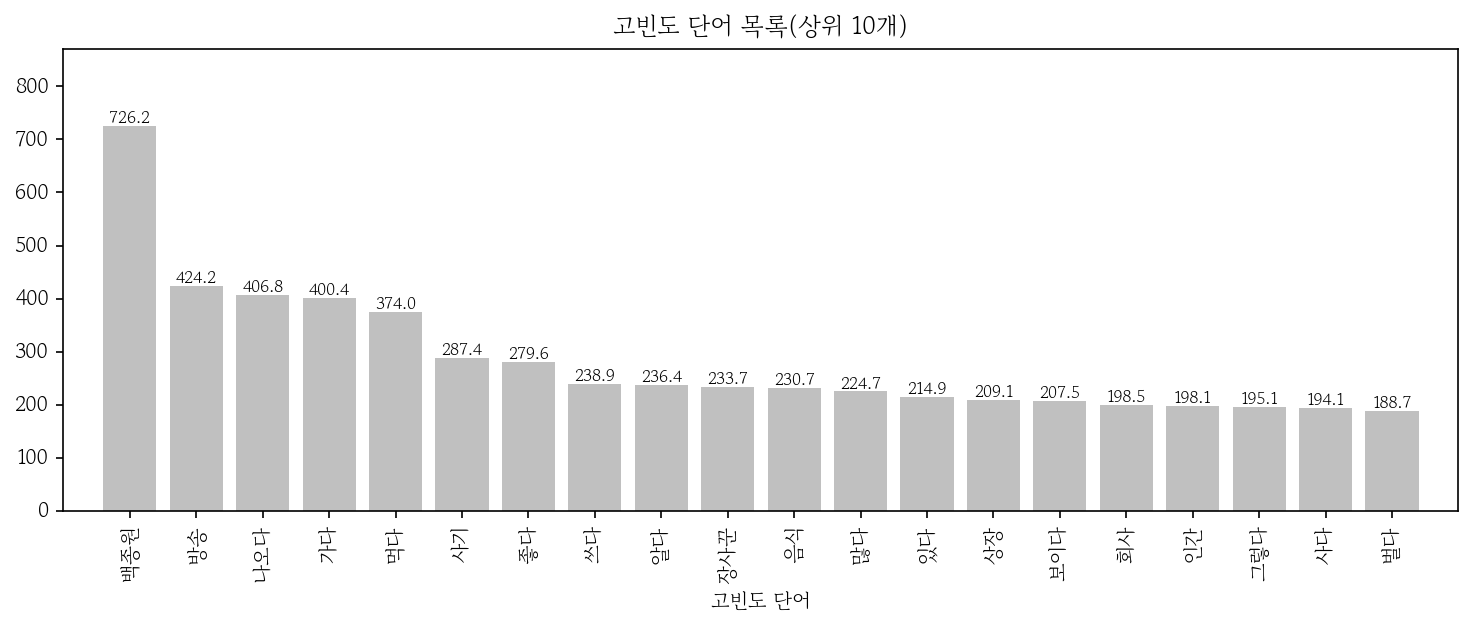

In [65]:
# 고빈도 상위 20개 단어를 막대 그래프로 시각화합니다.
highFreqs = termFreqs.head(n = 20)
sns.barplot(x = highFreqs.index, y = highFreqs.values, color = 'silver')
plt.title(label = '고빈도 단어 목록(상위 10개)')
plt.xlabel(xlabel = '고빈도 단어')
plt.xlim(-1, 20)
plt.ylim(0, highFreqs.max() * 1.2)
plt.xticks(rotation = 90)
for i, v in enumerate(highFreqs):
    plt.text(x = i, y = v, s = f'{v:.1f}', ha = 'center', va = 'bottom', fontsize = 8);

### 연관 단어 시각화

In [66]:
# 단어 간 상관계수 행렬을 corMat에 할당합니다.
# [참고] 열(차원) 개수가 많을수록 연산 시간이 길어집니다.
corMat = dtm.corr().round(4)

In [67]:
# corMat의 일부 행과 열을 확인합니다.
corMat.iloc[0:10, 0:10]

,가게,가격,가공,가깝다,가능,가다,가르치다,가리다,가맹점,가맹점주
가게,1.0000,0.0215,-0.0030,-0.0001,-0.0038,0.0455,0.0036,-0.0035,0.0194,-0.0023
가격,0.0215,1.0000,0.0134,0.0016,-0.0026,-0.0006,0.0037,-0.0045,0.0155,-0.0015
가공,-0.0030,0.0134,1.0000,-0.0012,0.0317,-0.0060,-0.0014,-0.0015,-0.0030,-0.0021
가깝다,-0.0001,0.0016,-0.0012,1.0000,-0.0015,-0.0021,0.0030,0.0049,0.0046,-0.0019
가능,-0.0038,-0.0026,0.0317,-0.0015,1.0000,-0.0038,0.0039,0.0023,0.0050,-0.0026
가다,0.0455,-0.0006,-0.0060,-0.0021,-0.0038,1.0000,-0.0049,-0.0026,0.0078,0.0013
가르치다,0.0036,0.0037,-0.0014,0.0030,0.0039,-0.0049,1.0000,-0.0016,-0.0034,-0.0023
가리다,-0.0035,-0.0045,-0.0015,0.0049,0.0023,-0.0026,-0.0016,1.0000,0.0028,-0.0024
가맹점,0.0194,0.0155,-0.0030,0.0046,0.0050,0.0078,-0.0034,0.0028,1.0000,0.0114
가맹점주,-0.0023,-0.0015,-0.0021,-0.0019,-0.0026,0.0013,-0.0023,-0.0024,0.0114,1.0000


In [68]:
# 키워드의 연관 단어로 막대 그래프를 그리는 함수를 생성합니다.
def plot_assocs(keyword, n = 20, pal = 'Reds_r'):
    assocs = corMat[keyword].sort_values(ascending = False).head(n = n + 1).iloc[1:]
    max_value = assocs.values.max()
    sns.barplot(x = assocs.index, y = assocs.values, hue = assocs.index, palette = pal)
    plt.title(label = '연관 단어 목록')
    plt.xlabel(xlabel = '고빈도 단어')
    plt.xlim(-1, 20)
    plt.ylim(0, max_value * 1.2)
    plt.xticks(rotation = 90)
    for i, v in enumerate(assocs):
        plt.text(x = i, y = v, s = f'{v:.2f}', ha = 'center', va = 'bottom', fontsize = 8)

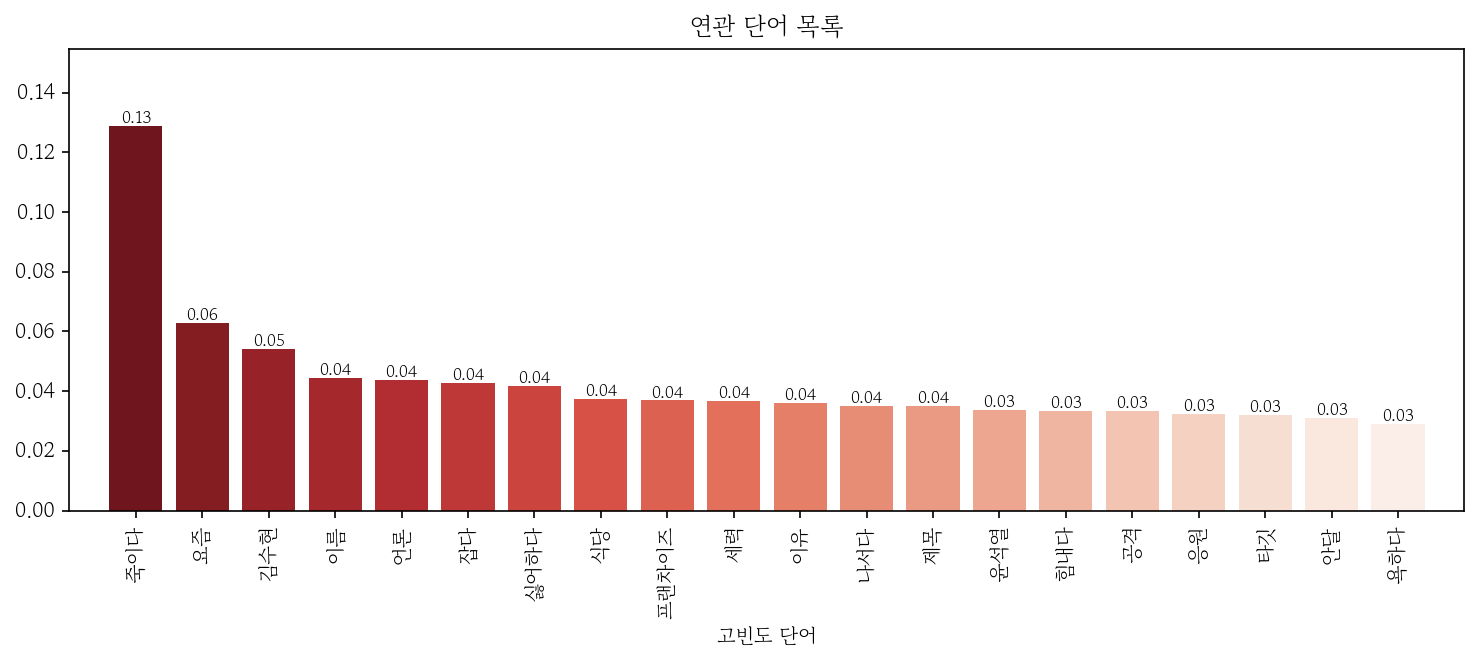

In [69]:
# 키워드의 연관 단어를 막대 그래프로 시각화합니다.
plot_assocs(keyword = '백종원')

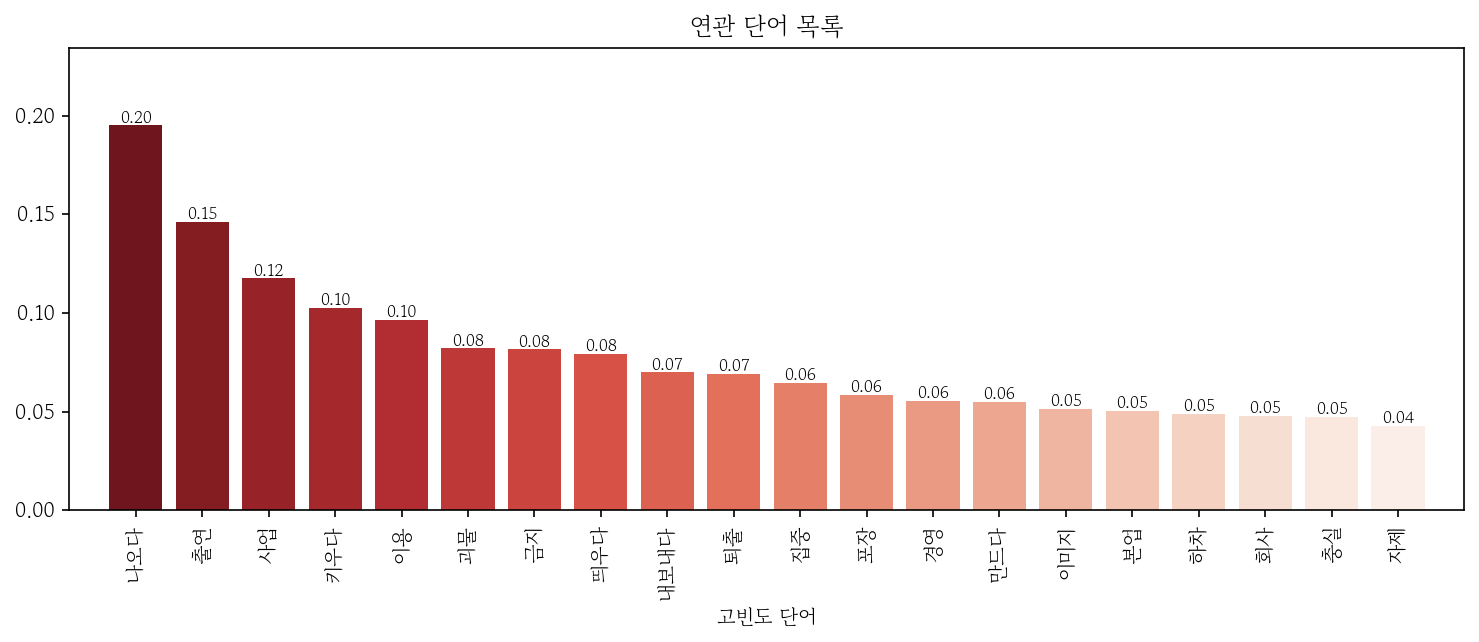

In [70]:
# 키워드의 연관 단어를 막대 그래프로 시각화합니다.
plot_assocs(keyword = '방송')

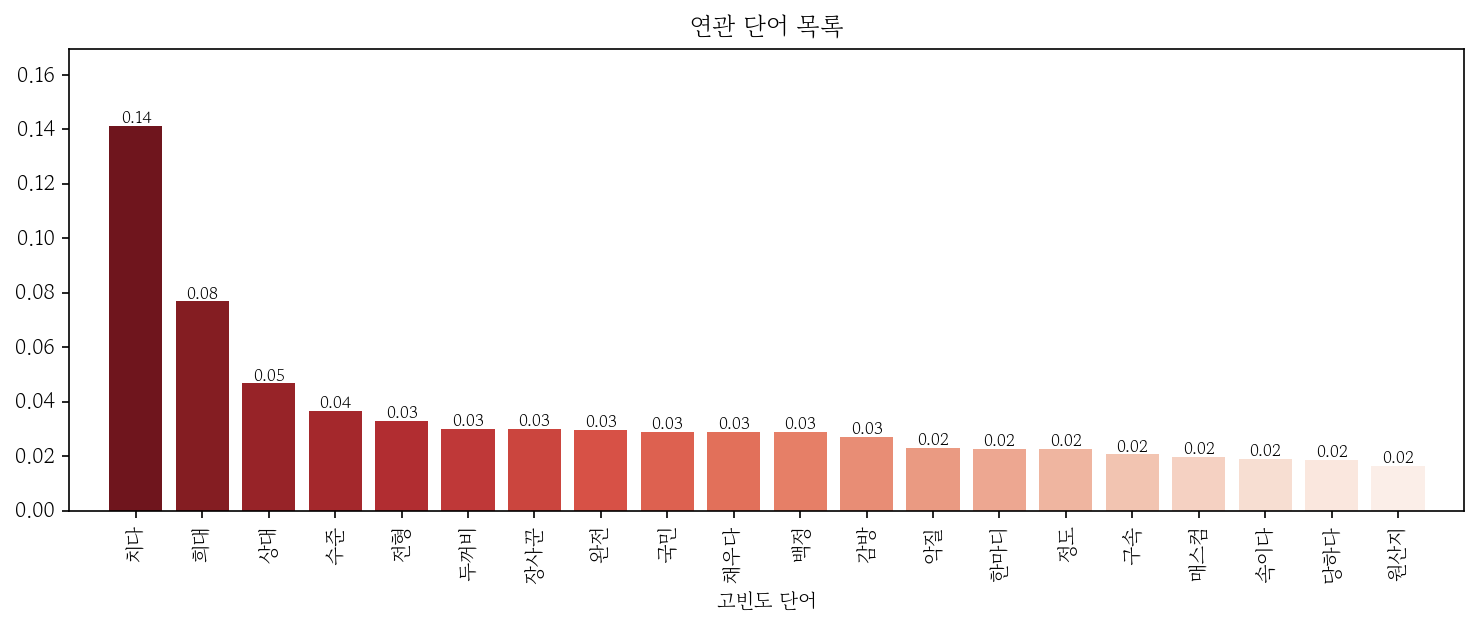

In [71]:
# 키워드의 연관 단어를 막대 그래프로 시각화합니다.
plot_assocs(keyword = '사기')

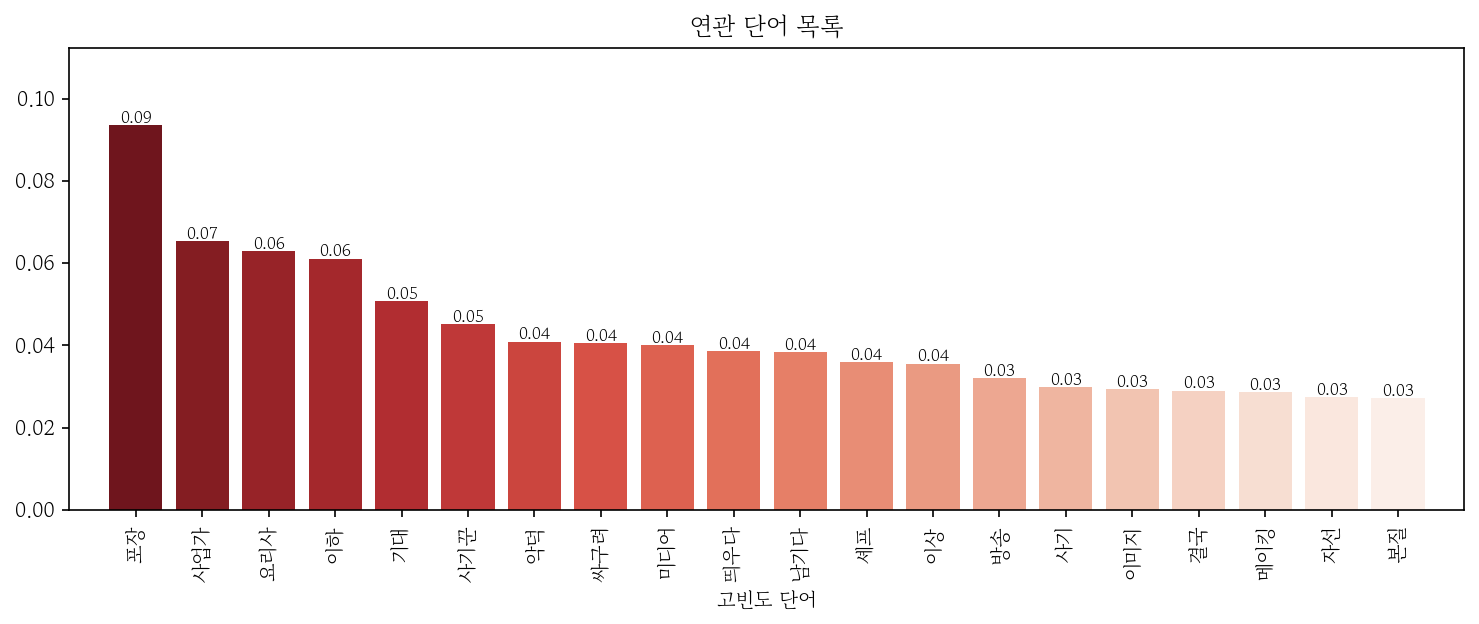

In [72]:
# 키워드의 연관 단어를 막대 그래프로 시각화합니다.
plot_assocs(keyword = '장사꾼')

## End of Document